# Overview

This Jupyter notebook predicts large-area tiles downloaded in `4a-download-large-area` with a trained model from `3-model-master`. The notebook is broken down into the following sections:

   * **Model loading**:
   * **Coordinate identification**
   * **Tiling**
   * **Loading and predicting**
   * **Mosaicing**
   * **Writing TIF**
   * **Writing COG**

# 1.0 Package imports

In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize
import hickle as hkl
from time import sleep

%run ../src/downloading/utils.py
%run ../src/models/utils.py

Using TensorFlow backend.


# 1.1 Parameter definitions

In [2]:
LANDSCAPE = 'elsalvador-imposible'
YEAR = 2018

In [3]:
database = pd.read_csv("../project-monitoring/database.csv")
coords = database[database['landscape'] == LANDSCAPE]
path = coords['path'].tolist()[0]
coords = (float(coords['longitude']), float(coords['latitude']))

IO_PARAMS = {'prefix': '../',
             'bucket': 'restoration-monitoring',
             'coords': coords,
             'bucket-prefix': '',
             'path': path}

OUTPUT = IO_PARAMS['prefix'] + IO_PARAMS['path'] + str(YEAR) + '/output/'
TIF_OUTPUT = IO_PARAMS['prefix'] + IO_PARAMS['path'] + str(YEAR) + ".tif"
INPUT = IO_PARAMS['prefix'] + IO_PARAMS['path'] + str(YEAR) + '/processed/'

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
    
print(coords, OUTPUT)

(-90.015579, 13.727333999999999) ../project-monitoring/el-salvador/ahuachapan/san-francisco-menendez/2018/output/


In [4]:
#OUTPUT = "../project-monitoring/brazil/sao-paulo/joanopolis/2019/output/"
#INPUT = "../project-monitoring/brazil/sao-paulo/joanopolis/2019/processed/"
# = "../project-monitoring/brazil/sao-paulo/joanopolis/2019.tif"

# 2.0 Model loading

In [ ]:
import urllib.request
import zipfile

if not os.path.exists("../models/master/"):
    os.makedirs("../models/master/")
    
    print("Downloading model file from cloud storage")
    urllib.request.urlretrieve("https://storage.googleapis.com/rm-models/master.zip", "master.zip")
    with zipfile.ZipFile("master.zip", 'r') as zip_ref:
        zip_ref.extractall("../models/")

In [4]:
path = '../models/master-nov/'
#path = "../models/eastafrica/117-87-2/" # master
new_saver = tf.train.import_meta_graph(path + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(path))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/master-nov/model


In [5]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")


inp_median = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")
dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_7:0")

## 2.2 Tiling functions

100 81 90 90 361
(140, 140)


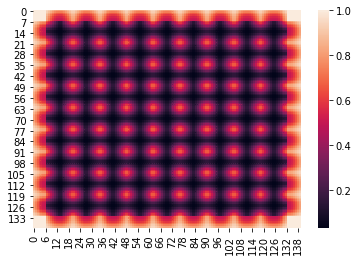

In [6]:
def fspecial_gauss(size, sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """

    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

arr = fspecial_gauss(14, 3.5)
arr = arr[:7, :7]

SIZE = 10
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)

arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums
sns.heatmap(normal)
print(upright.shape)

In [7]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA
%run ../src/pca/pca_filter.py

def load_reference_years(input_year, target_year):
    inp = np.empty((24, 5, 5, 142, 142, 17))
    targ = np.empty((24, 5, 5, 142, 142, 17))
    for x in tnrange(0, 5):
        for y in range(0, 5):
            inp_x = hkl.load(f"../tile_data/{LANDSCAPE}/{str(input_year)}/processed/{str(x)}/{str(y)}.hkl")
            targ_x = hkl.load(f"../tile_data/{LANDSCAPE}/{str(target_year)}/processed/{str(x)}/{str(y)}.hkl")
            inp[:, x, y, ...] = inp_x[...,]
            targ[:, x, y, ...] = targ_x[...]
    inp = inp.reshape(24, 5*5*142*142, 17)
    targ = targ.reshape(24, 5*5*142*142, 17)
    return inp, targ

def identify_pif_pca(input_year, reference):
    pif_mask = numpy.ones((142* 142*5*5), dtype=numpy.bool)
    for date in range(0, 24, 2):
        for band in range(0, 5):
            pif_band_mask = pca_fit_and_filter_pixel_list(input_year[date, ..., band].flatten(),
                                            reference[date, ..., band].flatten(),
                                            660)
            pif_mask = numpy.logical_and(pif_mask, pif_band_mask)
            print(np.sum(pif_mask))
    return np.argwhere(pif_mask == True)

def identify_pifs_new(input_year, reference):
    x = input_year[:, :, :10]
    x = np.swapaxes(x, 0, 1).reshape(142*142*5*5, 24*10)
    y = reference[:, ..., :10]
    y = np.swapaxes(y, 0, 1).reshape(142*142*5*5, 24*10)
    cca = CCA(n_components=2)
    xs, ys = cca.fit_transform(x, y)
    diffs = abs(xs - ys)
    diffs = np.sum(diffs**2, axis = 1)
    diffs = (diffs - np.mean(diffs)) / np.std(diffs)
    diffs = np.argwhere(diffs > np.percentile(diffs, 99.9))
    return diffs#np.argwhere(diffs < np.percentile(diffs, 1))

def identify_pifs_pairs(input_year, reference):
    diffs_all = np.zeros(142*142*5*5)
    for date in tnrange(0, 24):
        x = input_year[date, ..., :10].reshape(142*142*5*5, 10)
        y = reference[date, ..., :10].reshape(142*142*5*5, 10)
        cca = CCA(n_components=2)
        cca.fit(x, y)
        xs = cca.transform(x)
        ys = cca.transform(y)
        diffs = np.sum(abs(xs - ys)**2, axis = 1)
        diffs = diffs.reshape(142*142*5*5)
        diffs_all += diffs
    print(diffs_all.shape)
    diffs = np.argwhere(diffs_all < np.percentile(diffs_all, 0.1))
    return diffs

def identify_pifs(input_year, reference):
    pearsons = np.empty(142*142*5*5)
    input_year = input_year[..., 3].reshape(24, 142*142*5*5)
    reference = reference[..., 3].reshape(24, 142*142*5*5)
    
    for i in tnrange(pearsons.shape[0]):
        pearsons[i] = pearsonr(input_year[:, i], reference[:, i])[0]
    
    pifs = np.argwhere(pearsons > np.percentile(pearsons, 99))
    #stacked = np.concatenate([input_year, reference], axis = 0)
    #stacked = stacked[..., 3].reshape(48, 142*142*5*5)
    #stacked = np.percentile(stacked, 75, 0) - np.percentile(stacked, 25, 0)
    #pifs = np.argwhere(stacked < np.percentile(stacked, 2))
    #diffs = abs( 1 - (abs(input_year[..., 3] / reference[..., 3])) )#
    #diffs = diffs.reshape(24, 142*142)
    #diffs = np.std(diffs, axis = (0))
    #pifs = np.argwhere((diffs < 0.05))
    return pifs, pearsons


def linear_adjust_pif(pifs, small_input, small_target, large_input, large_target):
    output = small_input.copy()
    
    for date in range(0, 24):
        for band in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14]:
            input_ = large_input[:, pifs, band]
            target = large_target[:, pifs, band]
            
            target_date = target[date].squeeze()[:, np.newaxis]
            input_date = input_[date].squeeze()[:, np.newaxis]
            reg = LinearRegression().fit(input_date, target_date)
            input_updated = reg.predict(small_input[date, ..., band].reshape(142*142, 1))

            output[date, ..., band] = input_updated.reshape(1, 142, 142)
    return output

#sns.scatterplot([x for x in range(len(diffs))], sorted(diffs))

<Figure size 432x288 with 0 Axes>

# 2.3 Prediction functions

In [8]:
min_all = [0.016768555792030362,
 0.031859364002449986,
 0.018888066882654337,
 0.08300588143157157,
 0.04900411763090337,
 0.07196114637821546,
 0.0790915859490633,
 0.08027978003529285,
 0.05206992316991091,
 0.033226898834616644,
 0.0,
 0.0029407649199765626,
 -0.026773188909673434,
 0.0032562207477167242,
 0.006299999542534351,
 4.999999873689376e-05]

max_all = [0.21292338743805878,
 0.29813900702779483,
 0.4300807791948318,
 0.5124803858995437,
 0.4764584118127815,
 0.4890428495407102,
 0.5156670875445272,
 0.5284151314082131,
 0.6588925588130947,
 0.6016234779357905,
 0.37872035768296985,
 0.7223387521306766,
 0.40211242556571936,
 0.6531514992624433,
 0.7853250503540039,
 0.15389999747276306]


def load_and_predict_folder(y_col, folder, overlap_filter = upright,
                            normal_filter = normal, histogram_match = False):
    pred_files = INPUT + str(y_col) + "/" + str(folder) + ".hkl"
    reference_files = f"../tile_data/{LANDSCAPE}/2019/processed/{str(y_col)}/{str(folder)}.hkl"
    
    pred_x = []
    
    clipping_params = {
        'rmax': rmax,
        'rmin': rmin,
        'dmax': dmax
    }

    x = hkl.load(pred_files)
    x = np.float32(x)
    
                       
    if histogram_match and YEAR < 2019:
        reference = hkl.load(reference_files)
        x = linear_adjust_pif(pifs, x, reference, inpt, targ)
        #for date in range(0, 24):
            #x[date] = hist_match(x[date], reference[date])

    filtered = median_filter(x[0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (71, 2, 71, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (142, 142), 0)
    x[:, :, :, 10] = np.stack([filtered] * 24)
    
    for band in range(x.shape[-1]):
        if np.max(x[..., band]) > 100:
            x[..., band] /= 65535
    
    x = np.delete(x, 14, -1)
    
    if x.shape[0] == 24:
        x = np.reshape(x, (12, 2, 142, 142, 16))
        x = np.mean(x, axis = 1)
    x = tile_images(x)

    pred_x = np.stack(x)     
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[..., x] = np.clip(pred_x[..., x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[..., x] - midrange) / (rng / 2)
        pred_x[..., x] = standardized

    preds = []
    batches = [x for x in range(0, 341, 20)] + [361]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        median_x = np.median(batch_x, axis = (1))
        lengths = np.full((batch_x.shape[0], 1), 12)
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, 
                                                 inp_median: median_x,
                                                 clipping_params['rmax']: 5,
                                                 clipping_params['rmin']: 0,
                                                 clipping_params['dmax']: 3,
                                                 length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
            
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0) * normal

    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright

    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked

# 2.4 Run predictions

In [9]:
all_preds = []
for row in tnrange((0*5), (3*5)): 
    for column in range(0*5, 3*5):
        output_file = f"{OUTPUT}{str(row)}/{str(column)}.npy"
        input_file = f"{INPUT}{str(row)}/{str(column)}.hkl"

        if os.path.exists(input_file) and not os.path.exists(output_file):
            prediction = load_and_predict_folder(row, column, histogram_match = False)
            if not os.path.exists(OUTPUT + str(row) + "/"):
                os.makedirs(OUTPUT + str(row) + "/")
            prediction = prediction[7:-7, 7:-7]
            np.save(output_file, prediction)


# 2.5 Mosaic predictions

In [10]:
max_x = 3*5
max_y = 3*5

start_x = 0*5
start_y = 0*5

predictions = np.full(
    ((max_y-start_y)*126,
     (max_x-start_x)*126), 0, dtype = np.uint8 )

max_y_out = predictions.shape[0]
max_x_out = predictions.shape[1]

numb = 0
for row in tnrange(start_y, max_y):
    for column in range(start_x, max_x):
        input_file = f"{OUTPUT}{str(row)}/{str(column)}.npy"
        if os.path.exists(input_file):
            prediction = np.load(input_file)
            x_value = (column-start_x) *126
            y_value = (max_y_out - ((row - start_y + 1) *126))
            if (row % 5 == 0) and (column % 5 == 0):
                numb += 1
            predictions[y_value:y_value+126, 
                        x_value:x_value+126,
                        ] = (prediction * 255).astype(np.uint8)
            
print(f"There are {numb*4000} hectares processed")


There are 28000 hectares processed


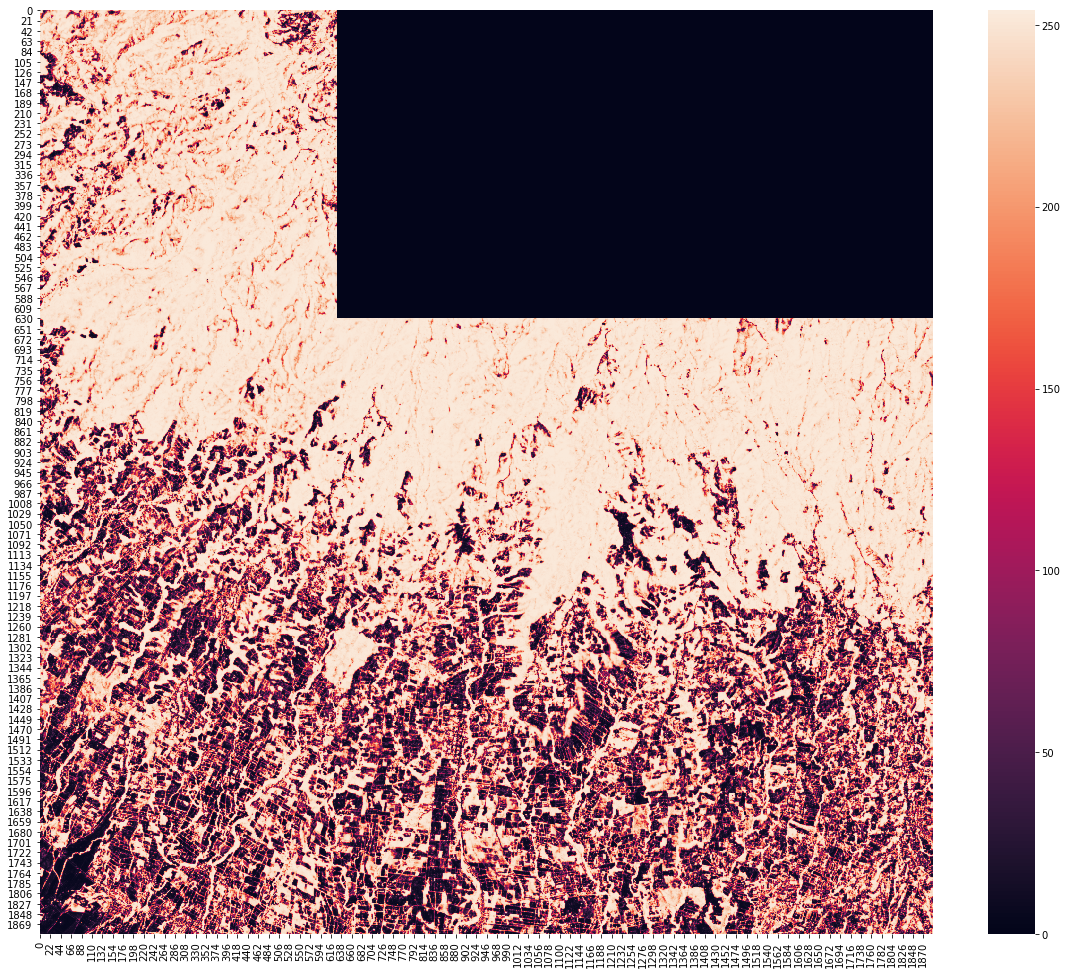

In [11]:
# 24 time step
#x_shape = predictions.shape[1] / predictions.shape[0] * 17
plt.figure(figsize=(20, 17))
sns.heatmap(predictions, vmin = 0)

#### 2.6 Sharpen predictions

In [ ]:
def recover_new(arr, thresh):
    adding = 0
    stacked = np.copy(arr)
    for window_x in tnrange(2, stacked.shape[0]-2, 1):
        for window_y in range(2, stacked.shape[1]-2, 1):
            #
            five_w = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
            three_w = stacked[window_x-1:window_x+2, window_y-1:window_y+2]
            
            n_five_above = len(five_w[np.argwhere(five_w > 0.15)])
            n_three_above = len(three_w[np.argwhere(three_w > 0.15)])
            
            n_five_below = len(five_w[np.argwhere(five_w < thresh)])
            
            
            if n_five_below >= 24:                 # if less than 2 of the 5x5 are positive
                if n_three_above >= 2 and n_three_above < 6:             # and at least 2 of the 3x3 are above 0.1
                    if n_three_above <= (n_five_above + 4):  # and less than 1/4 of the outer border is above 0.1
                        if np.argmax(three_w) == 4:          # and the center of the 3 x 3 is the largest
                            stacked[window_x, window_y] = -1.
                            #print("adding")
                            adding += 1
    stacked[np.where(stacked == -1)] = 1.
    return stacked

In [12]:
stacked = predictions
#stacked = recover_new(predictions, 0.3)
#stacked[np.where(stacked < 0.3)] = 0.

In [13]:
#plt.figure(figsize=(20, 17))
#thresh_p = 0.55
#stacked = predictions
#stacked[np.where(stacked > thresh_p)] = 0.71
#stacked[np.where(stacked < thresh_p)] = -1
#stacked[np.where(stacked == 1.0)] = 1.
#sns.heatmap(stacked)

# 3.0 Write GeoTiff

In [14]:
point = bounding_box(coords, (max_x*1260)-0, ((max_y)*1260)-0, expansion = 0)
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]
print(max_y)

15


In [15]:
stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.uint8)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[0])

print("Writing", TIF_OUTPUT)
new_dataset = rasterio.open(TIF_OUTPUT, 'w', driver = 'GTiff',
                           height = stacked.shape[0], width = stacked.shape[1], count = 1,
                           dtype = 'uint8',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

Writing ../project-monitoring/el-salvador/ahuachapan/san-francisco-menendez/2018.tif


# 3.1 Cloud optimized Geotiff

In [ ]:
!gdal_translate ../../ce-hosting/includes/drc-kafubu.tif ../tile_data/cog/drc-kafubu.tif \
               -co TILED=YES -co COMPRESS=LZW
!gdaladdo -r average -ro ../tile_data/cog/drc-kafubu.tif 2 4 8 16
#!gsutil cp niger.tif gs://restoration-hosting/niger.tif

# 3.2 Half-hectare tree density Geotiff

In [ ]:
summed = np.reshape(stacked, (stacked.shape[0] // 6, 6, stacked.shape[1] // 6, 6))
summed = np.sum(summed, (1, 3))
summed /= np.max(summed)
summed = np.clip(summed, 0, 0.8)
summed += 0.1

In [ ]:

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/bonanza1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()